In [171]:
import numpy as np
import pandas as pd
import json
import uuid
import os
import random

from scipy import misc
from keras.layers import Convolution2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, ZeroPadding2D, Lambda, ELU, BatchNormalization
from keras.models import Sequential, model_from_json
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from zimpy.camera_preprocessor import preprocess_image

Training data was collected in the Self-Driving Car simulator on Mac OS using a Playstation 3 console controller.

### Recording Measurement class

To simplify accessing each measurement from the original CSV, I've encapsulated each row in a special class.

It serves the following purposes:

  1. Strips whitespace off the left, center, and right camera image paths.
  2. Casts the original absolute path of each camera image to a relative path.
     This adds reassurance the image will load on any computer.
  3. Provides a convenient #is_valid_measurment method which encapsulates pertinent logic to ensure data quality 
     is satisfactory.
  4. Provides convenience getter methods for left, center and camera images. They're essentially designed to 
     lazily instantiate (once) the actual image array at the time the method is invoked.

In [172]:
class RecordingMeasurement:
    """
    A representation of a vehicle's state at a point in time while driving 
    around a track during recording.
    
    Features available are:
    
        left_camera_view   - An image taken by the LEFT camera.
        center_camera_view - An image taken by the CENTER camera.
        right_camera_view  - An image taken by the RIGHT camera.
        steering_angle     - A normalized steering angle in the range -1 to 1.
        speed              - The speed in which the vehicle was traveling at measurement time.
        
        
    This class serves the following purposes:

      1. Strips whitespace off the left, center, and right camera image paths.
      2. Casts the original absolute path of each camera image to a relative path.
         This adds reassurance the image will load on any computer.
      3. Provides a convenient #is_valid_measurment method which encapsulates pertinent logic to ensure data quality 
         is satisfactory.
      4. Provides convenience getter methods for left, center and camera images. They're essentially designed to 
         lazily instantiate (once) the actual image array at the time the method is invoked.
         
    """
    def __init__(self, measurement_data):
        self.measurement_data = measurement_data
        
        self.steering_angle = round(float(measurement_data['steering']), 4)
        self.speed = round(float(measurement_data['speed']), 4)
        
        l = measurement_data['left'].strip()
        c = measurement_data['center'].strip()
        r = measurement_data['right'].strip()
        
        # cast absolute path to relative path to be environment agnostic
        l, c, r = [('./IMG/' + os.path.split(file_path)[1]) for file_path in (l, c, r)]

        self.left_camera_path = l
        self.center_camera_path = c
        self.right_camera_path = r
    
    def is_valid_measurement(self):
        return os.path.isfile(self.center_camera_path)
    
    def left_camera_view(self):
        if not hasattr(self, '__left_camera_view'):
            self.__left_camera_view = self.__load_image(self.left_camera_path)
        return self.__left_camera_view
    
    def center_camera_view(self):
        print('A')
        if not hasattr(self, '__center_camera_view'):
            print('B')
            self.__center_camera_view = self.__load_image(self.center_camera_path)
        print('C')
        return self.__center_camera_view
    
    def right_camera_view(self):
        if not hasattr(self, '__right_camera_view'):
            self.__right_camera_view = self.__load_image(self.right_camera_path)
        return self.__right_camera_view
    
    def __load_image(self, imagepath):
        image_array = None
        if os.path.isfile(imagepath):
            image_array = misc.imread(imagepath)
            print(image_array.shape)
        else:
            print('File Not Found: {}'.format(imagepath))
        return image_array

### Track 1 Training Dataset class

In [173]:
import math

class Track1TrainingDataset:
    """
    Parses driving_log.csv and constructs training and test datasets corresponding to 
    measurements taken at various points in time while recording on track 1.
    """
    
    DRIVING_LOG_PATH = './driving_log.csv'
    
    def __init__(self, validation_split_percentage=0.01):
        self.load(validation_split_percentage=validation_split_percentage)
    
    def load(self, validation_split_percentage=0.01):
        X_train, y_train = [], []

        if os.path.isfile(self.DRIVING_LOG_PATH):
            df = pd.read_csv(self.DRIVING_LOG_PATH)
            headers = list(df.columns.values)
            for index, measurement_data in df.iterrows():
                measurement = RecordingMeasurement(measurement_data=measurement_data)
                X_train.append(measurement)
                y_train.append(measurement.steering_angle)

        # Split some of the training data into a validation dataset
        X_train, X_val, y_train, y_val = train_test_split(
            X_train,
            y_train,
            test_size=validation_split_percentage,
            random_state=0)

        X_train, y_train, X_val, y_val = np.array(X_train), np.array(y_train, dtype=np.float32), np.array(X_val), np.array(
            y_val, dtype=np.float32)
        
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.df = df
        self.headers = headers
        
        return self.X_train, self.y_train, self.X_val, self.y_val
    
    def batch_generator(self, X, Y, label, num_epochs, batch_size=32, output_shape=None, flip_images=True, classifier=None):
        population = len(X)
        counter = 0
        _index_in_epoch = 0
        _tot_epochs = 0
        batch_size = min(batch_size, population)
        batch_count = int(math.ceil(population / batch_size))

        print('Batch generating against the {} dataset with population {} and shape {}'.format(label, population, X.shape))
        while True:
            counter += 1
            print('batch gen iter {}'.format(counter))
            for i in range(batch_count):
                start_i = _index_in_epoch
                _index_in_epoch += batch_size
                if _index_in_epoch >= population:
                    # Save the classifier to support manual early stoppage
                    if classifier is not None:
                        classifier.save()
                    print('  sampled entire population. reshuffling deck and resetting all counters.')
                    perm = np.arange(population)
                    np.random.shuffle(perm)
                    X = X[perm]
                    Y = Y[perm]
                    start_i = 0
                    _index_in_epoch = batch_size
                    _tot_epochs += 1
                end_i = _index_in_epoch

                X_batch = []
                y_batch = []
                
                for j in range(start_i, end_i):
                    steering_angle = Y[j]
                    measurement = X[j]
                    center_image = measurement.center_camera_view()
                    print(center_image)
                    # raise Exception('FAIL')

                    if center_image is not None:
                        image = preprocess_image(center_image, output_shape=output_shape)
                        if flip_images and random.random() > 0.5:
                            X_batch.append(np.fliplr(image))
                            y_batch.append(-steering_angle)
                        else:
                            X_batch.append(image)
                            y_batch.append(steering_angle)

                yield np.array(X_batch), np.array(y_batch)

    def __str__(self):
        results = []
        results.append('[Headers]')
        results.append('  {}'.format(self.headers))
        results.append('[Shapes]')
        results.append('  X_train: {}'.format(self.X_train.shape))
        results.append('  y_train: {}'.format(self.y_train.shape))
        results.append('  X_val: {}'.format(self.X_val.shape))
        results.append('  y_val: {}'.format(self.y_val.shape))
        return '\n'.join(results)

Instantiates the Track 1 training dataset, prints details about the object then prints the first 5 elements of the dataframe.

In [174]:
dataset = Track1TrainingDataset()
print(dataset)
print(dataset.df.head(n=5))

[Headers]
  ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
[Shapes]
  X_train: (18691,)
  y_train: (18691,)
  X_val: (189,)
  y_val: (189,)
                                   center  \
0  IMG/center_2016_12_01_13_30_48_287.jpg   
1  IMG/center_2016_12_01_13_30_48_404.jpg   
2  IMG/center_2016_12_01_13_31_12_937.jpg   
3  IMG/center_2016_12_01_13_31_13_037.jpg   
4  IMG/center_2016_12_01_13_31_13_177.jpg   

                                    left  \
0   IMG/left_2016_12_01_13_30_48_287.jpg   
1   IMG/left_2016_12_01_13_30_48_404.jpg   
2   IMG/left_2016_12_01_13_31_12_937.jpg   
3   IMG/left_2016_12_01_13_31_13_037.jpg   
4   IMG/left_2016_12_01_13_31_13_177.jpg   

                                    right  steering  throttle  brake  \
0   IMG/right_2016_12_01_13_30_48_287.jpg       0.0       0.0    0.0   
1   IMG/right_2016_12_01_13_30_48_404.jpg       0.0       0.0    0.0   
2   IMG/right_2016_12_01_13_31_12_937.jpg       0.0       0.0    0.0   
3   IMG/right

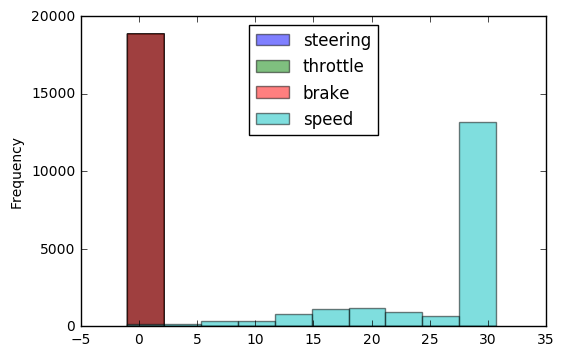

In [175]:
%matplotlib inline
import matplotlib.pyplot as plt
dataset.df.plot.hist(alpha=0.5)

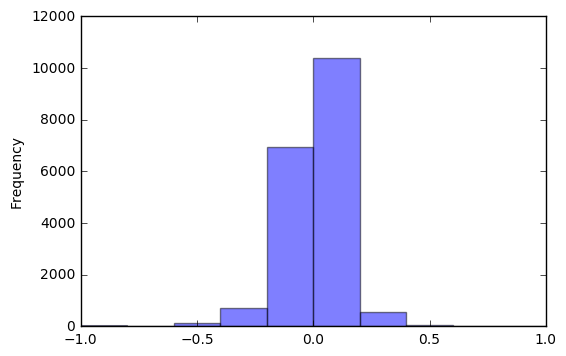

In [176]:
dataset.df['steering'].plot.hist(alpha=0.5)

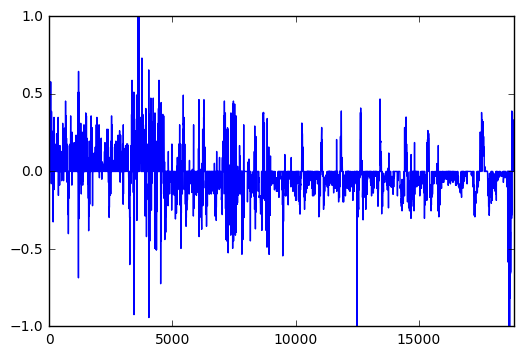

In [177]:
dataset.df['steering'].plot()

Explore the features

In [178]:
# Randomize the training date and inject to first 10 measurements into the batch generator.
perm = np.arange(len(dataset.X_train))
np.random.shuffle(perm)        
generator = dataset.batch_generator(X=dataset.X_train[perm[0:1]], Y=dataset.y_train[perm[0:1]], output_shape=(40, 80, 3), label='batch feature exploration', num_epochs=1, batch_size=32)

In [179]:
print(dataset.X_train[0].steering_angle)
print(dataset.X_train[0].center_camera_view())

0.1479
A
B
File Not Found: ./IMG/center_2016_12_18_22_45_26_690.jpg
C
None


Batch generating against the batch feature exploration dataset with population 1 and shape (1,)
batch gen iter 1
  sampled entire population. reshuffling deck and resetting all counters.
A
B
File Not Found: ./IMG/center_2016_12_17_02_05_59_744.jpg
C
None
(0,)
(0,)


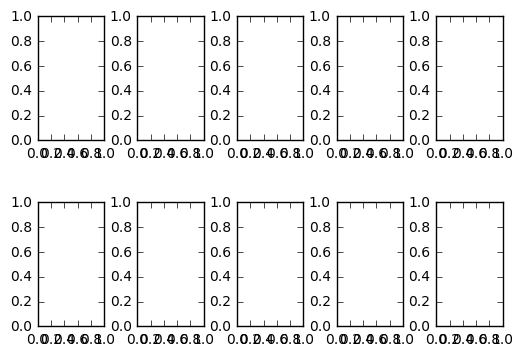

In [180]:
from zimpy.plot.image_plotter import ImagePlotter

# Grab the first 10 items from the training set and 
X_batch, y_batch = next(generator)
print(X_batch.shape)
print(y_batch.shape)

ImagePlotter.plot_images(X_batch, y_batch, rows=2, columns=5)

#### Network Architecture

BaseNetwork is the base class for all network implementation. It contains the necessary plumbing to save trained network data, load previously trained model and weights, and implements the abstract #fit method which all sub classes must implement.

In [181]:
class BaseNetwork:
    
    WEIGHTS_FILE_NAME = 'model_final.h5'
    MODEL_FILE_NAME = 'model_final.json'
    
    def __init__(self):
        self.uuid = uuid.uuid4()
        self.model = None
        self.weights = None

    def fit(self, X_train, y_train, X_val, y_val, nb_epoch=2, batch_size=32, samples_per_epoch=None, output_shape=(40, 80, 3)):
        raise NotImplementedError
        
    def get_model(self, input_shape, output_shape, learning_rate=0.001, dropout_prob=0.1, activation='relu'):
        raise NotImplementedError

    def save(self):
        print('Saved {} model.'.format(self.__class__.__name__))
        self.__persist()

    def __persist(self):
        save_dir = os.path.join(os.path.dirname(__file__))
        weights_save_path = os.path.join(save_dir, WEIGHTS_FILE_NAME)
        model_save_path = os.path.join(save_dir, MODEL_FILE_NAME)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        self.model.save_weights(weights_save_ath)
        with open(model_save_path, 'w') as outfile:
            json.dump(self.model.to_json(), outfile)

    def __str__(self):
        results = []
        if self.model is not None:
            results.append(self.model.summary())
        return '\n'.join(results)

Track1 extends BaseNetwork.

It contains a simple 4-layer convolutional neural network with 4 fully connected layers with 10% dropout after flattening the data as well as after the first FC layer.

In [182]:
class Track1(BaseNetwork):
    def fit(self, model, dataset, nb_epoch=2, batch_size=32, samples_per_epoch=None):

        # Fit the model
        # I wrote a custom batch generator with the main goal 
        # of reducing memory footprint on GPU with limited 
        # memory space.
        history = model.fit_generator(
            dataset.batch_generator(
                X=dataset.X_train, 
                Y=dataset.y_train, 
                label='train set', 
                num_epochs=nb_epoch,
                batch_size=batch_size,
                output_shape=output_shape,
                classifier=self
            ),
            nb_epoch=nb_epoch,
            samples_per_epoch=len(X_train),
            verbose=2,
            validation_data=dataset.batch_generator(
                X=dataset.X_val, 
                Y=dataset.y_val,
                label='validation set',
                num_epochs=nb_epoch,
                batch_size=batch_size,
                output_shape=output_shape
            )
        )
        
        print(history.history)
        self.save()
    
    def get_model(self, input_shape, output_shape, learning_rate=0.001, dropout_prob=0.1, activation='relu'):
        """
        Inital zero-mean normalization input layer.
        A 4-layer deep neural network with 4 fully connected layers at the top.
        ReLU activation used on each convolution layer.
        Dropout of 10% (default) used after initially flattening after convolution layers.
        Dropout of 10% (default) used after first fully connected layer.
        
        Adam optimizer with 0.001 learning rate (default) used in this network.
        Mean squared error loss function was used since this is a regression problem and MSE is 
        quite common and robust for regression analysis.
        """
        model = Sequential()
        model.add(Lambda(lambda x: x / 255 - 0.5,
                         input_shape=input_shape,
                         output_shape=output_shape))
        model.add(Convolution2D(24, 5, 5, border_mode='valid', activation=activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Convolution2D(36, 5, 5, border_mode='valid', activation=activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Convolution2D(48, 5, 5, border_mode='same', activation=activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Convolution2D(64, 3, 3, border_mode='same', activation=activation))
        model.add(Flatten())
        model.add(Dropout(dropout_prob))
        model.add(Dense(1024, activation=activation))
        model.add(Dropout(dropout_prob))
        model.add(Dense(100, activation=activation))
        model.add(Dense(50, activation=activation))
        model.add(Dense(10, activation=activation))
        model.add(Dense(1, init='normal'))

        optimizer = Adam(lr=learning_rate)
        model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        self.model = model
        model.summary()
        return model

#### Instantiate the classifier

In [183]:
output_shape=(40, 80, 3)

clf = Track1()
model = clf.get_model(
    input_shape=output_shape, 
    output_shape=output_shape, 
    learning_rate=0.001, 
    dropout_prob=0.1, 
    activation='relu'
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 40, 80, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 36, 76, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 18, 38, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 34, 36)    21636       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

#### Train the network

In [184]:
if False:
    clf.fit(
        model, 
        dataset, 
        nb_epoch=2, 
        batch_size=32
    )